# Introduction to RNNs

Goal of the lab is to:
    * Implement a simple RNN
    * Understand vanishing gradients in RNNs
    * Revisit code conventions: PyTorch data loader, functional model construction, more standard trainig loop
    
References:
    * Content heavily based on https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/402_RNN.ipynb (I highly recommend the whole repository)
    * http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/

# Whiteboard exercises

(Plus any left out exercise from the previous labs)

<img width=500 src="http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt-with-gradients.png">

* (0.5) Find  in literature at least two ways to combat vanishing gradients in RNNs *without* changing the architecture. Describe them and argue why they should work. 

* (0.5) Describe how Truncated Back Propagation Through Time (TBPTT) would work for the network in the figure. Argue why TBPTT, with a correctly chosen cutoff, can be an effective method (e.g. not leading to inaccurate gradients and not slowing convergence) of training?


# Setup

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict
%matplotlib inline
import json

In [2]:
# Hyper Parameters (constant for the notebook)
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
LR = 0.001
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

In [3]:
# A standard way to load a dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
# shape (2000, 28, 28) value in range(0,1)
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


# Exercise 1: Code your own RNN

Code your own RNN. It will be defined by two layers:

* i2h: takes *input and hidden state from the previous step* and *produce new hidden state* using equation $$h_{t+1}=tanh(W input_{t+1} + U h_{t})$$

* h2o: taken hidden state and produces $$o_{t+1} = softmax(Vh_{t+1})$$ (note that in pytorch softmax is applied within the cross entropy loss function)

Tasks:

* Fill up missing blanks to train your own RNN!
* Save results as a figure (10a_1.png)

Starting code is provided.

Expected outcome:

<img width=300 src="https://raw.githubusercontent.com/gmum/nn2018/master/lab/fig/10/ex1_expected.png"> 

In [4]:
 class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, init_strategy="simple", init_scale=0.01):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear((input_size + hidden_size), hidden_size) ## Hint: linear module, from (input size + hidden_size) to hidden_size
        self.h2o = nn.Linear(hidden_size, output_size) # Hint: linear module
        
        if init_strategy == "simple":
            self.i2h.weight.data.normal_(0, init_scale)
        else:
            raise NotImplementedError()
        
        self.i2h.bias.data.fill_(0)
        self.h2o.weight.data.uniform_(0, init_scale)
        self.h2o.bias.data.fill_(0)
            

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # Hint: use torch.cat to combine input and hidden input 2d vector
        hidden = F.tanh(self.i2h(combined)) # Hint: use input to hidden
        output = (self.h2o(hidden)) # Hint: use hidden to output
        return output, hidden
    

    def initHidden(self, batch_size):
        return Variable(torch.zeros(batch_size, self.hidden_size))

In [5]:
rnn = RNN(28, 64, 10)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [8]:
import torch

In [9]:
torch.__version__

'0.3.1.post2'

In [6]:
# training and testing
H = {"acc": []}
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y
        
        optimizer.zero_grad()

        hidden = rnn.initHidden(b_x.size()[0])
        for i in range(b_x.size()[1]): # Hint: iterate through all the steps
            output, hidden = rnn.forward(b_x[:,i,:], hidden) # Hint: just apply forward from the model
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            hidden = rnn.initHidden(test_x.size()[0])
            for i in range(test_x.size()[1]):
                test_output, hidden = rnn(test_x[:, i], hidden)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y.reshape(-1,)) / float(test_y.size)
            H['acc'].append(accuracy)
            print('Epoch: ', epoch + step*len(b_x)/2000., '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)

C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0.0 | train loss: 2.3026 | test accuracy: 0.10
Epoch:  1.6 | train loss: 1.7826 | test accuracy: 0.26
Epoch:  3.2 | train loss: 1.4722 | test accuracy: 0.32
Epoch:  4.8 | train loss: 1.8017 | test accuracy: 0.40
Epoch:  6.4 | train loss: 1.5137 | test accuracy: 0.47
Epoch:  8.0 | train loss: 0.9988 | test accuracy: 0.52
Epoch:  9.6 | train loss: 1.6528 | test accuracy: 0.43
Epoch:  11.2 | train loss: 0.9502 | test accuracy: 0.49
Epoch:  12.8 | train loss: 1.2697 | test accuracy: 0.56
Epoch:  14.4 | train loss: 1.0570 | test accuracy: 0.57
Epoch:  16.0 | train loss: 0.9681 | test accuracy: 0.59
Epoch:  17.6 | train loss: 1.0845 | test accuracy: 0.58
Epoch:  19.2 | train loss: 1.8330 | test accuracy: 0.36
Epoch:  20.8 | train loss: 1.5641 | test accuracy: 0.51
Epoch:  22.4 | train loss: 1.0491 | test accuracy: 0.62
Epoch:  24.0 | train loss: 0.9258 | test accuracy: 0.65
Epoch:  25.6 | train loss: 1.5258 | test accuracy: 0.59
Epoch:  27.2 | train loss: 1.4475 | test accuracy: 0.57

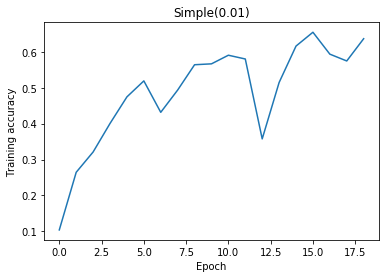

In [7]:
plt.title("Simple(0.01)")
plt.plot(H['acc'])
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.savefig("10a_1.png")

# Exercise 2: Vanishing Gradient


* Measure ||dL/dh_i|| for different states, where ||.|| is the euclidean norm of the vector. 
* Plot run for the simple initialization (with scale=0.001). Save figure to (10a_2_simple.png)

Starting code is provided

Expected (it can be different for you due to randomness) outcome (x axis is epoch, y axis is ||dL/dh_i||, color is index):

<img width=300 src="https://raw.githubusercontent.com/gmum/nn2018/master/lab/fig/10/ex2_expected_simple.png"> 

In [9]:
H = defaultdict(list)

rnn = RNN(28, 64, 10, "simple", 0.001)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
    
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y
        
        optimizer.zero_grad()

        # Make sure gradients are retained
        hidden = rnn.initHidden(b_x.size()[0])
        hiddens = [hidden]
        for i in range(b_x.size()[1]): # Hint: iterate through all the steps
            output, hidden = rnn.forward(b_x[:,i,:], hidden) # Hint: just apply forward from the model
            hiddens.append(hidden)
            hidden.retain_grad() # google "retain_grad". Otherwise hidden.grad=None. 
        loss = loss_func(output, b_y)
        
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward(retain_graph=True)      # backpropagation, compute gradients
        
        # Save ||dL/dh_i||
        dLdhi = []
        for h in hiddens[1:]:
            g = h.grad.data.numpy()
            dLdhi.append(np.linalg.norm(g)) # Hint: Just compute ||dL/dh_i|| from h.grad.data.numpy() using np.linalg.norm + average over examples
        
        optimizer.step()                                

        if step % 50 == 0:
            hidden = rnn.initHidden(test_x.size()[0])
            for i in range(test_x.size()[1]):
                test_output, hidden = rnn(test_x[:, i], hidden)
            
            for i, val in enumerate(dLdhi):
                H['dL/dh_{}'.format(i)].append(val)
                
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y.reshape(-1,)) / float(test_y.size)
            H['acc'].append(accuracy)
            print('Epoch: ', epoch + step*len(b_x)/2000., '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)

C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0.0 | train loss: 2.3026 | test accuracy: 0.10
Epoch:  1.6 | train loss: 1.7696 | test accuracy: 0.29
Epoch:  3.2 | train loss: 1.5594 | test accuracy: 0.34
Epoch:  4.8 | train loss: 1.0814 | test accuracy: 0.52
Epoch:  6.4 | train loss: 1.3015 | test accuracy: 0.48
Epoch:  8.0 | train loss: 2.0381 | test accuracy: 0.17
Epoch:  9.6 | train loss: 2.2300 | test accuracy: 0.14
Epoch:  11.2 | train loss: 2.0174 | test accuracy: 0.25
Epoch:  12.8 | train loss: 2.2865 | test accuracy: 0.17
Epoch:  14.4 | train loss: 1.7337 | test accuracy: 0.44
Epoch:  16.0 | train loss: 1.2268 | test accuracy: 0.43
Epoch:  17.6 | train loss: 1.6196 | test accuracy: 0.37
Epoch:  19.2 | train loss: 1.4098 | test accuracy: 0.43
Epoch:  20.8 | train loss: 1.9255 | test accuracy: 0.28
Epoch:  22.4 | train loss: 1.7060 | test accuracy: 0.32
Epoch:  24.0 | train loss: 1.4765 | test accuracy: 0.38
Epoch:  25.6 | train loss: 1.4990 | test accuracy: 0.39
Epoch:  27.2 | train loss: 1.3877 | test accuracy: 0.40

Ratio of ||dL/dh_27|| to ||dL/dh_1|| is 1.435539


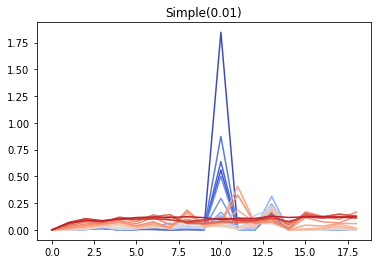

In [10]:
# Save results
cm = plt.get_cmap("coolwarm", 80)
plt.title("Simple(0.01)") 
for i in range(28):
    plt.plot(H['dL/dh_{}'.format(i)], color=cm(i/28.))
print("Ratio of ||dL/dh_27|| to ||dL/dh_1|| is " + str(np.mean(H['dL/dh_27'][-10:-1]) / np.mean(H['dL/dh_1'][-10:-1])))
plt.savefig("10a_2_simple.png") 